# Importing the data and splitting it into training and test data

In [124]:
import numpy as np
import random
random.seed(43)
#import seaborn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

#seaborn.set(style='whitegrid'); seaborn.set_context('talk')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

#from sklearn.datasets import load_iris
#iris_data = load_iris()


from sklearn.model_selection import train_test_split

In [125]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [126]:
#print(iris_data['DESCR'])

In [127]:
#data = np.column_stack((iris_data.data,iris_data.target.T)) #Joins the 4 features and the target variable which is encoded as 0,1,2 for setosa, versicolour and virginica

Since all the categories are one after the other, we need to shuffle it first

In [128]:
data=pd.read_csv(r"diabetes.csv")


#np.random.shuffle(data)

In [129]:
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


## train-test split and X and Y split

In [130]:
training, testing=train_test_split(data, test_size=0.2, train_size=0.8, random_state=43, shuffle=True, stratify=None)

train_X=training.iloc[:,:8]
train_y=training.iloc[:,8:]
test_X=training.iloc[:,:8]
test_y=training.iloc[:,8:]

#train_X.head()
#train_y.head()
#train_X.head()


from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
train_X = sc.fit_transform(train_X)
test_X = sc.transform(test_X)


# Multilayer Perceptron Implementation

## Activation function - Hyperbolic tangent

In [131]:
from sklearn.base import BaseEstimator, ClassifierMixin #base estimator is the base class for all estimators, classifier mixin returns the mean accuracy on the given test data and labels.

class MultilayerPerceptron(BaseEstimator,ClassifierMixin):
    def __init__(self):
        self.inputLayer = 8                        # number of neurons in Input Layer
        self.hiddenLayer = 5                       # number of neurons in Hidden Layer
        self.outputLayer = 2                       # number of neurons Output Layer
        self.learningRate = 0.001                  # Learning rate
        self.max_epochs = 1000                     # Epochs
        self.BiasHiddenValue = -1                   # Bias HiddenLayer
        self.BiasOutputValue = -1                  # Bias OutputLayer
        self.activation = self.tanh # Activation function
        self.deriv = self.deriv_tanh
        
        
        #defining the starting weights and biases
        self.WEIGHT_hidden = self.starting_weights(self.hiddenLayer, self.inputLayer)
        self.WEIGHT_output = self.starting_weights(self.outputLayer, self.hiddenLayer)
        self.BIAS_hidden = np.array([self.BiasHiddenValue for i in range(self.hiddenLayer)])
        self.BIAS_output = np.array([self.BiasOutputValue for i in range(self.outputLayer)])
        self.classes_number = 2 
        
    
    def tanh(self,x):
        return np.tanh(x)

    def deriv_tanh(self,x):
        return (1-(self.tanh(x)**2))
    
    def starting_weights(self, x, y):
        #return [[ random.uniform(0,0.5)for i in range(x)] for j in range(y)]
        return [[2  * random.random() - 1 for i in range(x)] for j in range(y)]

    
    def backpropagation(self,x):
        #Step 1- find the error in the output layer, update the weights and bias between output layer and hidden layer
        
        DELTA_output = []
        
        ERROR_output = self.output - self.OUTPUT_L2 #expected output- received output
        DELTA_output = ((-1)*(ERROR_output) * self.deriv(self.OUTPUT_L2)) # (error*deriv) why -1?
        
        for i in range(self.hiddenLayer):#loops to connect from each node in hidden layer (i) to each node in output layer (j)
            for j in range(self.outputLayer):
                self.WEIGHT_output[i][j] -= (self.learningRate * (DELTA_output[j] * self.OUTPUT_L1[i])) #(error*deriv(j)*output from prev layer(i))
                self.BIAS_output[j] -= (self.learningRate * DELTA_output[j])
        
        #Step 2- find the error in the hidden layer, update the weights and bias between hidden layer and input layer
        
        delta_hidden = np.matmul(self.WEIGHT_output, DELTA_output)* self.deriv(self.OUTPUT_L1) #formula for delta term for hidden layer= (delta term for output layer multiplied by the weight to the output layer) multiplied by the derivative of the input to the hidden layer 
        
        
        for i in range(self.inputLayer):
            for j in range(self.hiddenLayer):
                self.WEIGHT_hidden[i][j] -= (self.learningRate * (delta_hidden[j] * x[i]))#multiplying the delta term by the input 
                self.BIAS_hidden[j] -= (self.learningRate * delta_hidden[j])
        
    def show_err_graphic(self,v_erro,v_epochs):
        plt.figure(figsize=(9,4))
        plt.plot(v_epochs, v_erro, "m-",color="b", marker=11)
        plt.xlabel("Number of Epochs")
        plt.ylabel("Squared error (MSE) ");
        plt.title("Error Minimization")
        plt.show()
        
        
    def predict(self, X, y):#Returns the predictions for every element of X
        
        predictions = []

        forward = np.matmul(X,self.WEIGHT_hidden) + self.BIAS_hidden#input to hidden layer
        forward = np.matmul(forward, self.WEIGHT_output) + self.BIAS_output#hidden layer to output layer

        for i in forward:
            predictions.append(max(enumerate(i), key=lambda x:x[1])[0])#WHAT DOES THIS DO

        array_score = []# creating output table
        for i in range(len(predictions)):
            if predictions[i] == 0: 
                array_score.append([i, 'negative', predictions[i], y.iloc[i]])
            elif predictions[i] == 1:
                 array_score.append([i, 'positive', predictions[i], y.iloc[i]])


        dataframe = pd.DataFrame(array_score, columns=['_id', 'class', 'output', 'expected_output'])
        return predictions, dataframe
        
        
    def fit(self, X, y):  
        count_epoch = 1
        total_error = 0
        n = len(X); 
        epoch_array = []
        error_array = []
        W0 = []
        W1 = []
        while(count_epoch <= self.max_epochs):
            for idx,inputs in enumerate(X): 
                #initialize expected input
                self.output = np.zeros(self.classes_number)
                #forward propogation i.e activation((inputs * weights)+bias)
                self.OUTPUT_L1 = self.activation((np.dot(inputs, self.WEIGHT_hidden)) + self.BIAS_hidden.T)
                self.OUTPUT_L2 = self.activation(np.dot(self.OUTPUT_L1, self.WEIGHT_output) + self.BIAS_output.T)
                #giving values for expected input based on the ground truth we have in y                    
                if(y.iloc[idx].any() == 0): 
                    self.output = np.array([1,0]) 
                elif(y.iloc[idx].any() == 1):
                    self.output = np.array([0,1]) 
               

                square_error = 0
                for i in range(self.outputLayer):
                    erro=0

                    erro = (self.output[i] - self.OUTPUT_L2[i])**2
                    square_error = (square_error + (0.05 * erro))#1/2 * error squared
                    total_error = total_error + square_error
                    
                #now, backpropogate
                self.backpropagation(inputs)

                total_error = (total_error / n)
                if((count_epoch % 50 == 0)or(count_epoch == 1)):
                    print("Epoch ", count_epoch, "- Total Error: ",total_error)
                    error_array.append(total_error)
                    epoch_array.append(count_epoch)
                    
                W0.append(self.WEIGHT_hidden)
                W1.append(self.WEIGHT_output)

                count_epoch+=1


        self.show_err_graphic(error_array,epoch_array)

    
    

In [132]:
print(train_y.iloc[0])

Outcome    0
Name: 497, dtype: int64


Epoch  1 - Total Error:  0.000675773990973413
Epoch  50 - Total Error:  0.0006802247693897672
Epoch  100 - Total Error:  0.0001548895888199397
Epoch  150 - Total Error:  0.00012151463326601148
Epoch  200 - Total Error:  0.00030664875512689935
Epoch  250 - Total Error:  0.00031183146029707356
Epoch  300 - Total Error:  3.573682857790282e-05
Epoch  350 - Total Error:  9.227319782482724e-05
Epoch  400 - Total Error:  0.00024391517843114137
Epoch  450 - Total Error:  0.00025445419671145554
Epoch  500 - Total Error:  0.0001437925433984694
Epoch  550 - Total Error:  0.00030042909619258385
Epoch  600 - Total Error:  0.00010346707067756506
Epoch  650 - Total Error:  9.326919672767787e-05
Epoch  700 - Total Error:  4.96745111661739e-05
Epoch  750 - Total Error:  0.0002239590517719582
Epoch  800 - Total Error:  0.0001099454063231196
Epoch  850 - Total Error:  8.186679334352213e-05
Epoch  900 - Total Error:  0.0005144460777494614
Epoch  950 - Total Error:  0.00020707502000062594
Epoch  1000 - Tot

C:\Users\monik\AppData\Local\Temp\ipykernel_8652\2774408098.py:60: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "m-" (-> color='m'). The keyword argument will take precedence.
  plt.plot(v_epochs, v_erro, "m-",color="b", marker=11)


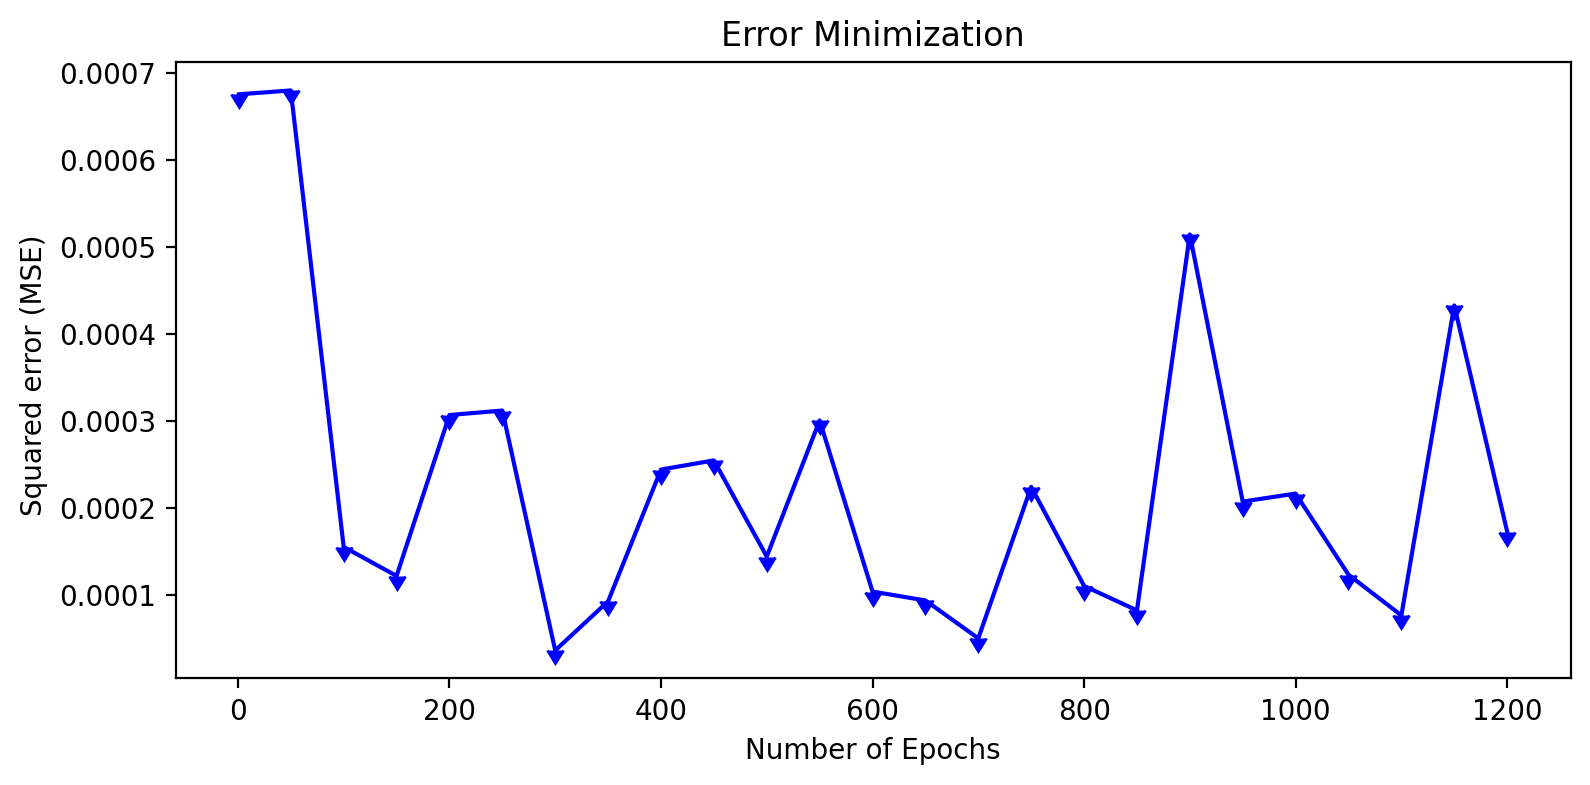

In [133]:
Perceptron = MultilayerPerceptron()
Perceptron.fit(train_X,train_y)


# Testing our neural network

In [134]:
pred, dataframe = Perceptron.predict(test_X, test_y)
hits = n_pos=n_neg= 0
score_neg = score_pos = 0
for j in range(len(test_y)):
    if(test_y.iloc[j].any() == 0): 
        n_neg += 1
    elif(test_y.iloc[j].any() == 1): 
        n_pos += 1
   
        
for i in range(len(test_y)):
    if test_y.iloc[i].any() == pred[i]: 
        hits += 1
    if test_y.iloc[i].any() == pred[i] and test_y.iloc[i].any() == 0:
        score_neg += 1
    elif test_y.iloc[i].any() == pred[i] and test_y.iloc[i].any() == 1:
        score_pos += 1
         
hits = (hits / len(test_y)) * 100
faults = 100 - hits

In [135]:
dataframe

,_id,class,output,expected_output
0,0,negative,0,"Outcome 0 Name: 497, dtype: int64"
1,1,negative,0,"Outcome 0 Name: 520, dtype: int64"
2,2,positive,1,"Outcome 1 Name: 236, dtype: int64"
3,3,negative,0,"Outcome 0 Name: 141, dtype: int64"
4,4,negative,0,"Outcome 0 Name: 727, dtype: int64"
...,...,...,...,...
609,609,negative,0,"Outcome 1 Name: 16, dtype: int64"
610,610,positive,1,"Outcome 0 Name: 58, dtype: int64"
611,611,positive,1,"Outcome 0 Name: 277, dtype: int64"
612,612,negative,0,"Outcome 1 Name: 255, dtype: int64"


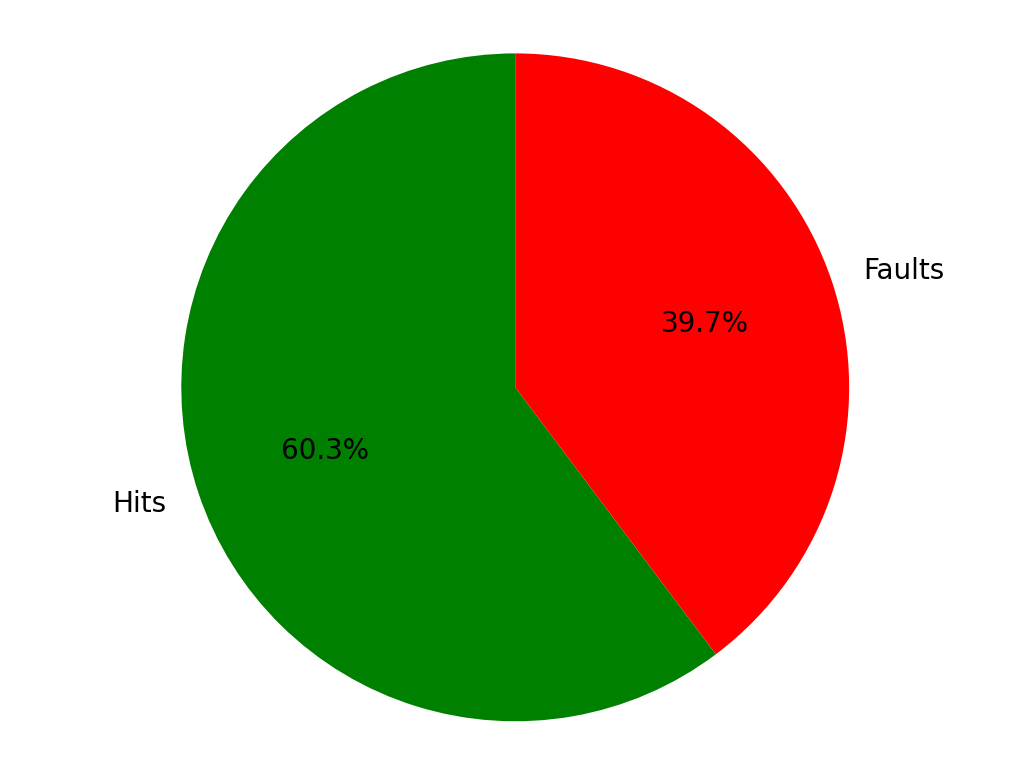

In [136]:
graph_hits = []


graph_hits.append(hits)
graph_hits.append(faults)
labels = 'Hits', 'Faults';
sizes = [96.5, 3.3]
explode = (0, 0.14)

fig1, ax1 = plt.subplots();
ax1.pie(graph_hits,colors=['green','red'],labels=labels, autopct='%1.1f%%',startangle=90)
ax1.axis('equal')
plt.show()